In [48]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
from skimage import io, transform
from tqdm import tqdm

class flower_mask_dataset(Dataset):
    
    def __init__(self, image_paths, mask_paths=None, mask_sizes=None, 
                 transform=None, mask_transform=None, in_memory=True):
        self.len = len(image_paths)
        self.transform = transform
        self.mask_transform = mask_transform
        self.in_memory = in_memory
        self.mask_sizes = mask_sizes
        
        if not self.in_memory:
            self.image_paths = image_paths
            if mask_paths is None:
                self.mask_paths = [None]*self.len
            else:
                self.mask_paths = mask_paths
            return
        
        self.image = []
        self.mask = []
        
        for i, path in tqdm(enumerate(image_paths)):
            image = io.imread(path)
            if (len(image.shape)!=3):
                self.len -= 1
                continue
                
            if self.transform is not None:
                image = self.transform(image)
            self.image.append(image)

            if mask_paths is None:
                self.mask.append(self.get_empty_masks())
            else:
                mask = io.imread(mask_paths[i], as_gray=True)
                masks = []
                for size in self.mask_sizes:
                    masks.append(self.get_mask(mask, size))
                self.mask.append(masks)

        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        if self.in_memory:
            return self.image[idx], self.mask[idx]
        else:
            image_path = self.image_paths[idx]
            image = io.imread(image_path)
            if self.transform is not None:
                image = self.transform(image)
            
            mask_path = self.mask_paths[idx]
            if mask_path is None:
                masks = self.get_empty_masks()
            else:
                mask = io.imread(mask_path)
                masks = []
                for size in self.mask_sizes:
                    masks.append(self.get_mask(mask, size))
            return image, masks
            
    def get_empty_masks(self):
            return [-torch.ones(1,size,size,dtype=torch.float32) for size in self.mask_sizes]
        
    def get_mask(self, mask_, size=None):
        mask = mask_
        if (size is not None):
            mask = transform.resize(mask, (size, size)).astype('float32')
        if self.mask_transform is not None:
            mask = self.mask_transform(np.expand_dims(mask,axis=-1))
        return mask

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
tqdm.pandas()

In [50]:
df = pd.read_csv('../input/mask_pred_dict.csv', header=None, names=['file','mean_mask'])
df['synset'] = df['file'].apply(lambda x: x.split('_')[0])
synset = df.groupby('synset').agg({'file':'count','mean_mask':'mean'}).sort_values('mean_mask', ascending=False)
df['synset_count'] = df['synset'].map(synset['file'])
df.head()

,file,mean_mask,synset,synset_count
0,n11721337_10018_1.jpg,0.408157,n11721337,1356
1,n11721337_10018_2.jpg,0.104775,n11721337,1356
2,n11721337_10066_1.jpg,0.628754,n11721337,1356
3,n11721337_10066_2.jpg,0.654473,n11721337,1356
4,n11721337_10088_1.jpg,0.081692,n11721337,1356


In [51]:
def mask_stats(mask_file, f=16, s=4):
    mask = io.imread(mask_file, is_gray=True)
    H,W = mask.shape
    grid = np.zeros([int((H-f)/s+1), int((W-f)/s+1)])
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            grid[i,j] = mask[i*s:i*s+f, j*s:j*s+f].mean()
    return grid.std(), grid.max()-grid.min()


df['mask_stats'] = df['file'].progress_apply(lambda x: mask_stats('../input/mask_pred64/mask_pred64/'+x))
df['std_mask'] = df['mask_stats'].apply(lambda x: x[0])
df['minmax_mask'] = df['mask_stats'].apply(lambda x: x[1])
df.head()

100%|██████████| 70638/70638 [02:46<00:00, 423.55it/s]


,file,mean_mask,synset,synset_count,mask_stats,std_mask,minmax_mask
0,n11721337_10018_1.jpg,0.408157,n11721337,1356,"(53.82545342878944, 182.9609375)",53.825453,182.960938
1,n11721337_10018_2.jpg,0.104775,n11721337,1356,"(12.35967658727604, 58.0)",12.359677,58.000000
2,n11721337_10066_1.jpg,0.628754,n11721337,1356,"(52.68175480723883, 205.3203125)",52.681755,205.320312
3,n11721337_10066_2.jpg,0.654473,n11721337,1356,"(49.222465769073274, 209.40625)",49.222466,209.406250
4,n11721337_10088_1.jpg,0.081692,n11721337,1356,"(14.836010908943878, 63.71484375)",14.836011,63.714844


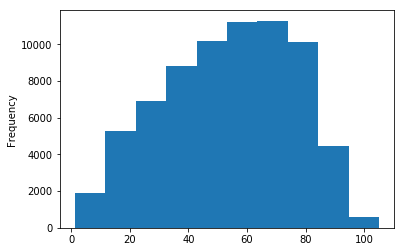

In [52]:
df['std_mask'].plot.hist()

In [53]:
mask_sizes = [64]
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

64it [00:00, 198.37it/s]


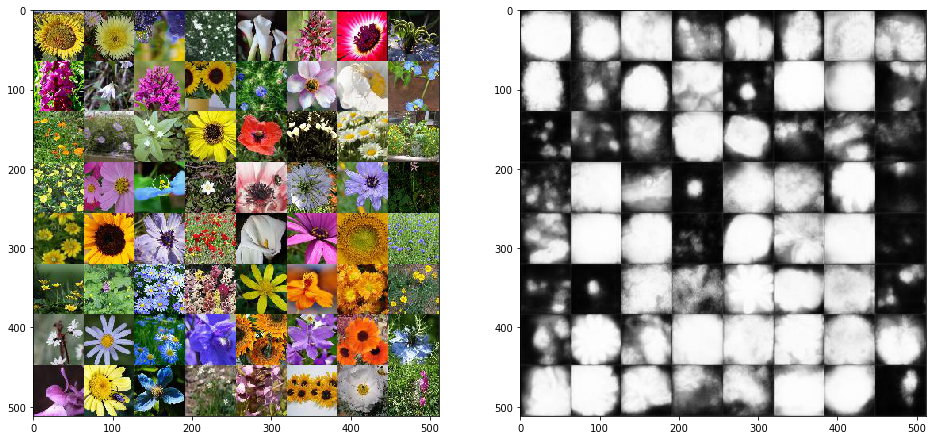

In [54]:
files = df['file'].loc[df['std_mask']<60].sample(64).values
image_paths = [os.path.join("../input/flower64/flower64", file) for file in files]
mask_paths = [os.path.join("../input/mask_pred64/mask_pred64", file) for file in files]
my_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
realflower = flower_mask_dataset(image_paths, mask_paths,
                            transform = my_transform,
                            mask_sizes = mask_sizes,
                            mask_transform = my_transform,
                            in_memory = True) 
realdata = realflower
dataloader = DataLoader(realdata, batch_size=128, shuffle=True, num_workers=1)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(vutils.make_grid(real_batch[1][-1].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.show()

64it [00:00, 180.03it/s]


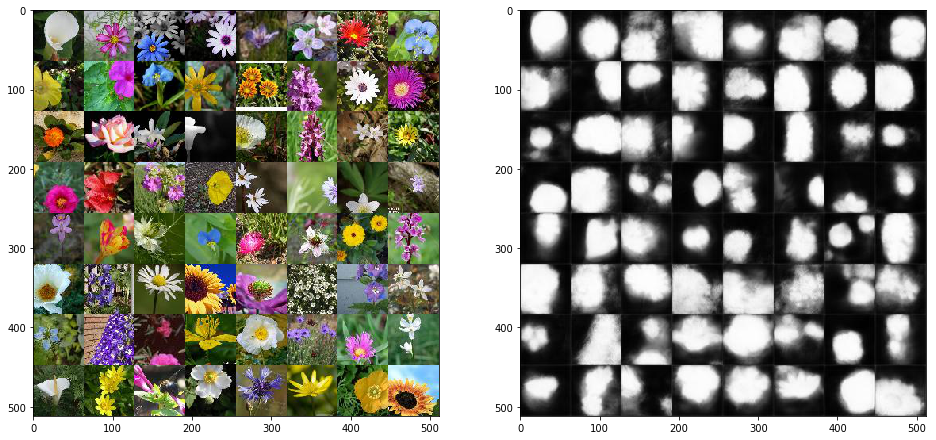

In [55]:
sampled_df = df.loc[df['mean_mask']<0.8]
sampled_df = sampled_df.loc[df['std_mask']>60]
sampled_df = sampled_df.loc[df['minmax_mask']>220]

files = sampled_df['file'].sample(64).values
image_paths = [os.path.join("../input/flower64/flower64", file) for file in files]
mask_paths = [os.path.join("../input/mask_pred64/mask_pred64", file) for file in files]
my_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
realflower = flower_mask_dataset(image_paths, mask_paths,
                            transform = my_transform,
                            mask_sizes = mask_sizes,
                            mask_transform = my_transform,
                            in_memory = True)
realdata = realflower
dataloader = DataLoader(realdata, batch_size=128, shuffle=True, num_workers=1)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16,8))
plt.axis("off")
plt.title("Training Images")
plt.subplot(1,2,1)
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.subplot(1,2,2)
plt.imshow(np.transpose(vutils.make_grid(real_batch[1][-1].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0)))
plt.show()

In [56]:
print(sampled_df.shape)
sampled_df.to_csv('mask_pred_dict_sampled.csv', index=False)

(27030, 7)
